# BASICS 02 - Training the network

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

/Users/laurentperrinet/quantic/science/HomeHots/HOTS_clone_laurent/HOTS


In [2]:
from Network import network, LoadFromMat
from tqdm import tqdm

datapath = "../Data/alphabet_ExtractedStabilized.mat"

# Loading the events

In [3]:
image_list = [1, 32, 19, 22, 29]
image_list += image_list
image_list += image_list
address, time, polarity, list_pola = LoadFromMat(datapath, image_number=image_list)

# Training

- krnlinit='first' means that the first 4 time-surfaces are used of initialisation of the layers
- with the .run method each event pass by all layers during training (learning of the different layers takes place simultaneously) 

In [4]:
hots = network(algo='lagorce', krnlinit='first')
count = 0
nbevent = int(time.shape[0])
pbar = tqdm(total=nbevent)
while count<nbevent:
    if time[count]<time[count-1]:
        for i in range(len(hots.TS)):
            hots.TS[i].spatpmat[:] = 0
            hots.TS[i].iev = 0
    pbar.update(1)
    hots.run(address[count,1],address[count,0],time[count],polarity[count],learn=True, to_record=True)
    count += 1
pbar.close()
for l in range(len(hots.L)):
    hots.stats[l].histo = hots.L[l].cumhisto.copy()

100%|██████████| 297828/297828 [03:02<00:00, 1629.55it/s]


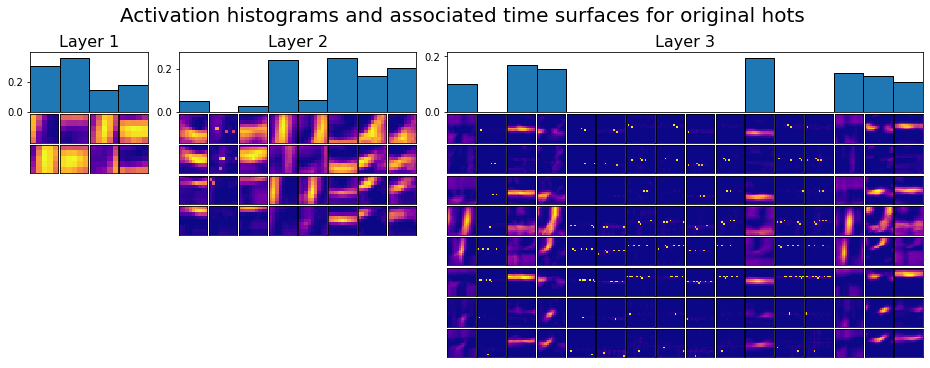

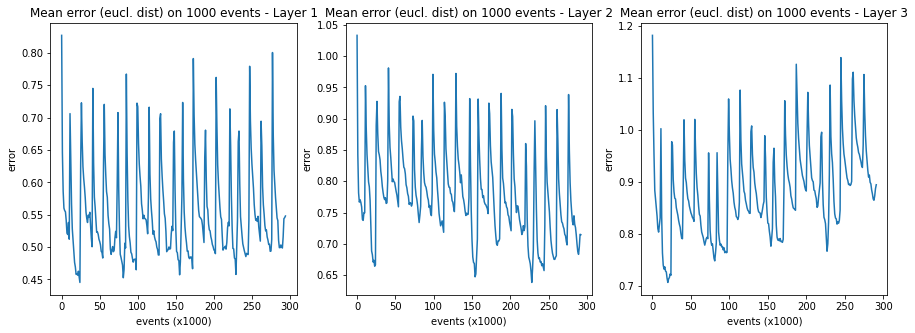

In [5]:
hots.plotlayer()
hots.plotconv()

# Training method including events loading

- this method of learning is inspired from KmeansLagorce and the first layer learns with all the events, then the second layer etc... 
- time-surfaces are filtered for minimum activation (2xR) only in the first layer

In [6]:
hots = network(algo='lagorce', krnlinit='first')
hots.learninglagorce(diginit=True)

100%|██████████| 297828/297828 [02:53<00:00, 1713.94it/s]


# Monitoring

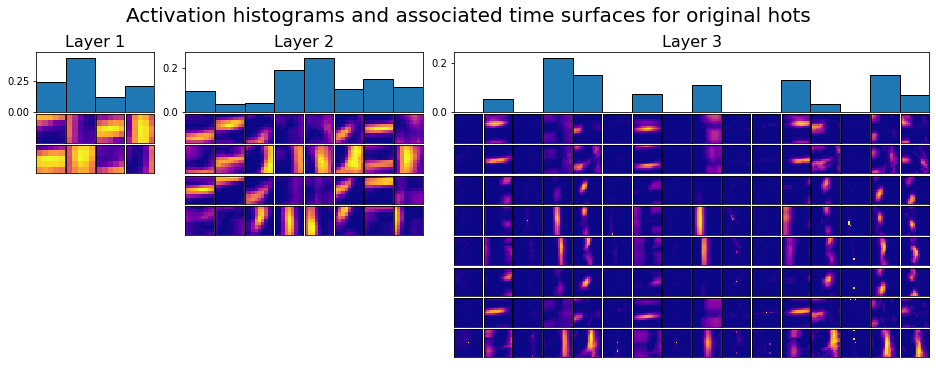

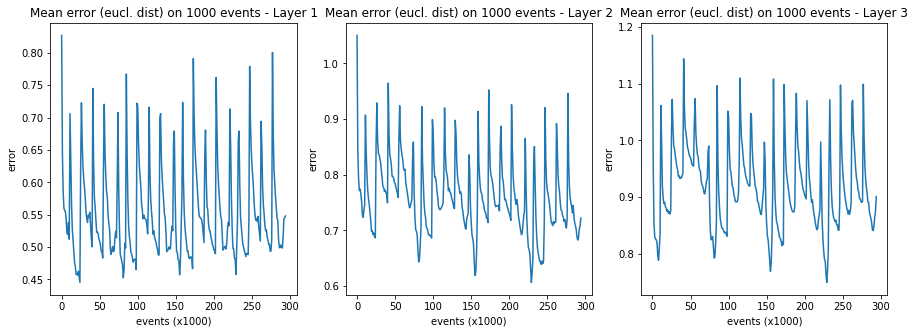

In [7]:
hots.plotlayer()
hots.plotconv()

# Running the trained network on a single image

TODO: what?
(you may have to uncommend one line in the .run method of Network.py)

In [8]:
## Loading and filter an image of a 8
address, time, polarity, list_pola = LoadFromMat(datapath, image_number=[15])

In [9]:
for i in range(len(hots.L)):
    hots.TS[i].spatpmat[:] = 0
    hots.TS[i].iev = 0

count = 0
nbevent = int(time.shape[0])
pbar = tqdm(total=nbevent)
while count<nbevent:
    pbar.update(1)     
    hots.run(address[count,1],address[count,0],time[count], polarity[count], to_record=True)
    count += 1
pbar.close()

100%|██████████| 28693/28693 [00:15<00:00, 1846.21it/s]


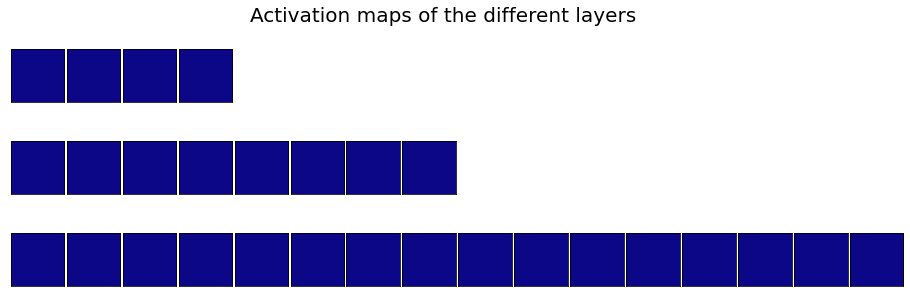

In [10]:
#you may have to uncomment line 286 (around this number to activat update of self.stats[lay].actmap)
#in mix_Network.py
hots.plotactiv()

## Trying harder filtering

In [11]:
for i in range(len(hots.TS)):
    hots.TS[i].spatpmat[:] = 0
    hots.TS[i].iev = 0
    hots.TS[i].filt = 3 #from 2 to 5
    hots.stats[i].actmap[:]=0

count = 0
nbevent = int(time.shape[0])
pbar = tqdm(total=nbevent)
while count<nbevent-1:
    pbar.update(1)
    count += 1
            
    hots.run(address[count,1],address[count,0],time[count], polarity[count], to_record=True)
            
pbar.close()

100%|█████████▉| 28692/28693 [00:15<00:00, 1853.17it/s]


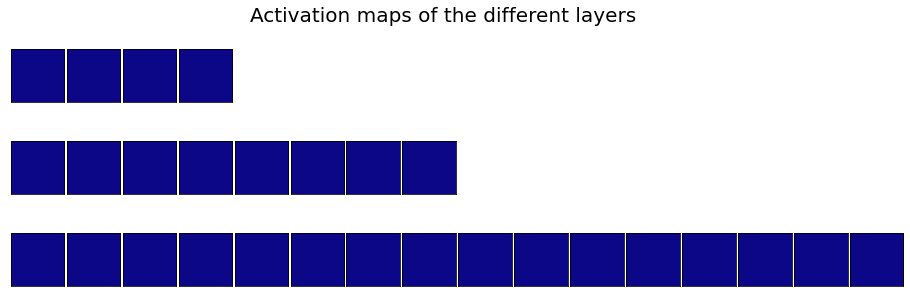

In [12]:
hots.plotactiv()